In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

In [3]:
# Download MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

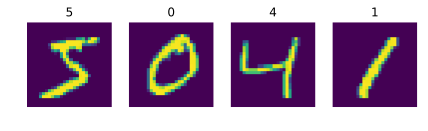

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(7, 3))
for img, label, ax in zip(x_train[:4], y_train[:4], axes):
    ax.set_title(label)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [5]:
print(f'train images: {x_train.shape}')
print(f'train labels: {y_train.shape}')
print(f' test images: {x_test.shape}')
print(f' test labels: {y_test.shape}')

train images: (60000, 28, 28)
train labels: (60000,)
 test images: (10000, 28, 28)
 test labels: (10000,)


In [6]:
# preprocessing
x_train = x_train.reshape(60000, 28 * 28) / 255
x_test = x_test.reshape(10000, 28 * 28) / 255

with tf.Session() as sesh:
    y_train = sesh.run(tf.one_hot(y_train, 10))
    y_test = sesh.run(tf.one_hot(y_test, 10))

In [41]:
# a one-hot array looks like
y_train[:4]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [33]:
# hyper parameters
learning_rate = 0.01
epochs = 20
batch_size = 100
batches = int(x_train.shape[0] / batch_size)

## lets see how to determine the shape of W and B

$\mathbf{Y}=\sigma(\mathbf{X}\cdot\mathbf{W} + \mathbf{B})$

$ 
\begin{pmatrix}
    y_1 \\ y_2 \\ \vdots \\ y_{10}
\end{pmatrix}=\sigma\left[
\begin{pmatrix}
    x_1 & x_2 & \dots & x_{784}
\end{pmatrix}
\begin{pmatrix}
    w_{1, 1} & w_{1, 2}  & \dots  & w_{1, 10} \\
    w_{2, 1} & w_{2, 2}  & \dots  & w_{2, 10} \\
    \vdots &  \vdots & \ddots & \vdots \\
    w_{784, 1} & w_{784, 2}  & \dots  & w_{784, 10}
\end{pmatrix} +
\begin{pmatrix}
    b_1 \\ b_2 \\ \vdots \\ b_{10}
\end{pmatrix}
\right]
$

#### Weights shape: 784, 10

#### Bias shape: 10

In [34]:
# inputs
# X is our "flattened / normalized" images
# Y is our "one hot" labels
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

# weights and bias
# weights convert X to same shape as Y
# bias is the same shape as Y
W = tf.Variable(0.1 * np.random.randn(784, 10).astype(np.float32))
B = tf.Variable(0.1 * np.random.randn(10).astype(np.float32))
# W = tf.Variable(np.zeros((784, 10)).astype(np.float32))
# B = tf.Variable(np.zeros(10).astype(np.float32))

In [35]:
# setup graph, cost, optimizer
pred = tf.nn.softmax(tf.add(tf.matmul(X, W), B))
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(pred), axis=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

## Lets look at how the cost function works

$
C = \sum -Y\ln(pred)
$

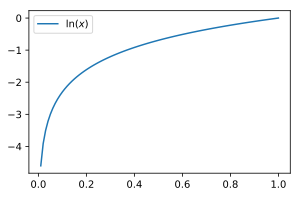

In [36]:
x = np.linspace(1/100, 1, 100)
fig, ax = plt.subplots(1, figsize=(4.7, 3))
ax.plot(x, np.log(x), label='$\ln(x)$')
ax.legend()
plt.show()

In [37]:
# sample data to compute the cost

a = np.log([[0.04, 0.13, 0.96, 0.12],    # correct prediction
            [0.01, 0.93, 0.06, 0.07]])   # incorrect prediction
b = np.array([[ 0,    0,    1,    0],    
              [ 1,    0,    0,    0]])   # labels
-a * b

array([[0.        , 0.        , 0.04082199, 0.        ],
       [4.60517019, 0.        , 0.        , 0.        ]])

In [38]:
# compute cost with numpy
r_sum = np.sum(-a * b, axis=1)
r_mean = np.mean(r_sum)

print(f' sum = {r_sum}')
print(f'mean = {r_mean:.5f}')

 sum = [0.04082199 4.60517019]
mean = 2.32300


In [39]:
# compute cost with tf
with tf.Session() as sesh:
    tf_sum = sesh.run(-tf.reduce_sum(a * b, axis=1))
    tf_mean = sesh.run(tf.reduce_mean(tf_sum))

print(f' sum = {tf_sum}')
print(f'mean = {tf_mean:.5f}')

 sum = [0.04082199 4.60517019]
mean = 2.32300


epoch: 0 cost=0.3095
epoch: 2 cost=0.5246
epoch: 4 cost=0.4477
epoch: 6 cost=0.4183
epoch: 8 cost=0.4542
epoch:10 cost=0.2156
epoch:12 cost=0.6075
epoch:14 cost=0.4172
epoch:16 cost=0.3644
epoch:18 cost=0.2440
Accuracy: 90.12%


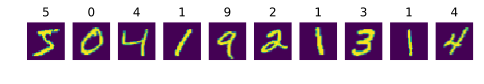

In [40]:
with tf.Session() as sesh:
    sesh.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        for i in range(batches):
            offset = i * epoch
            x = x_train[offset: offset + batch_size]
            y = y_train[offset: offset + batch_size]
            sesh.run(optimizer, feed_dict={X: x, Y:y})
            c = sesh.run(cost, feed_dict={X:x, Y:y})
        
        if not epoch % 2:
            print(f'epoch:{epoch:2d} cost={c:.4f}')
            
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    acc = accuracy.eval({X: x_test, Y: y_test})
    print(f'Accuracy: {acc * 100:.2f}%')
    
    fig, axes = plt.subplots(1, 10, figsize=(8, 4))
    for img, ax in zip(x_train[:10], axes):
        guess = np.argmax(sesh.run(pred, feed_dict={X: [img]}))
        ax.set_title(guess)
        ax.imshow(img.reshape((28, 28)))
        ax.axis('off')

## Lets look at how the cost function works

$
C = \sum -Y\ln(pred)
$

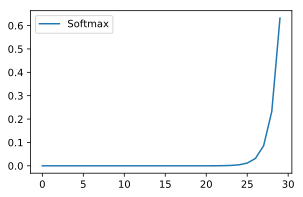

In [32]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

x = np.arange(30)
fig, ax = plt.subplots(1, figsize=(4.7, 3))
ax.plot(x, softmax(x), label='Softmax')
ax.legend()
plt.show()